In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, ks_2samp

# Display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Load the stage 3 property data
df = pd.read_csv(r'Output Files\stage_3_property_data.csv') 
df.head(3)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
0,Ready to Move,Immediately,20.0,Y,Tata Housing Development Company Ltd.,0.63,Rajoli naka,579.0,Tata Amantra,10880.0,579.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,34.0,Y,Sq-ft,New construction,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West
1,Ready to Move,Immediately,18.0,N,Sai Satyam Developers,0.54,This property has reputed scholl ints vicinity.,850.0,Sai Satyam Homes,6352.0,585.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,18.0,Y,Sq-ft,New construction,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West
2,Under Construction,Dec 25,5.0,N,Birla Estates,0.90,Shahad is one of the attractive locations to o...,1050.0,Birla Vanya,8571.0,815.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,27.0,Y,Sq-ft,NaN,3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West


In [3]:
# Check shape
df.shape

(6297, 120)

-----------------

#### <b>Top columns with missing values</b>

In [4]:
# Construct Dataframe for missing values
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_df.reset_index(drop=True, inplace=True)

# Sort by missing percentage
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

# Filter out columns with no missing values
missing_df_with_nulls = missing_df[missing_df['Missing_Count'] > 0]

# Separate columns to exclude
columns_to_exclude = ['Landmark', 'Unit of Covered Area', 'Unit of Carpet Area', 'Developer']
missing_for_imputation = missing_df_with_nulls[~missing_df_with_nulls['Column'].isin(columns_to_exclude)]

missing_for_imputation.reset_index(drop=True, inplace=True)
missing_for_imputation


,Column,Missing_Count,Missing_Percentage
0,Balconies,3340,53.04
1,Property Lifespan,2689,42.70
2,Facing,1666,26.46
3,Carpet Area,1117,17.74
4,Covered Area,636,10.10
5,sqft Price (INR),610,9.69
6,Total Floors,405,6.43
7,Floor No,400,6.35
8,Furnished Type,51,0.81
9,Price (Crores),47,0.75


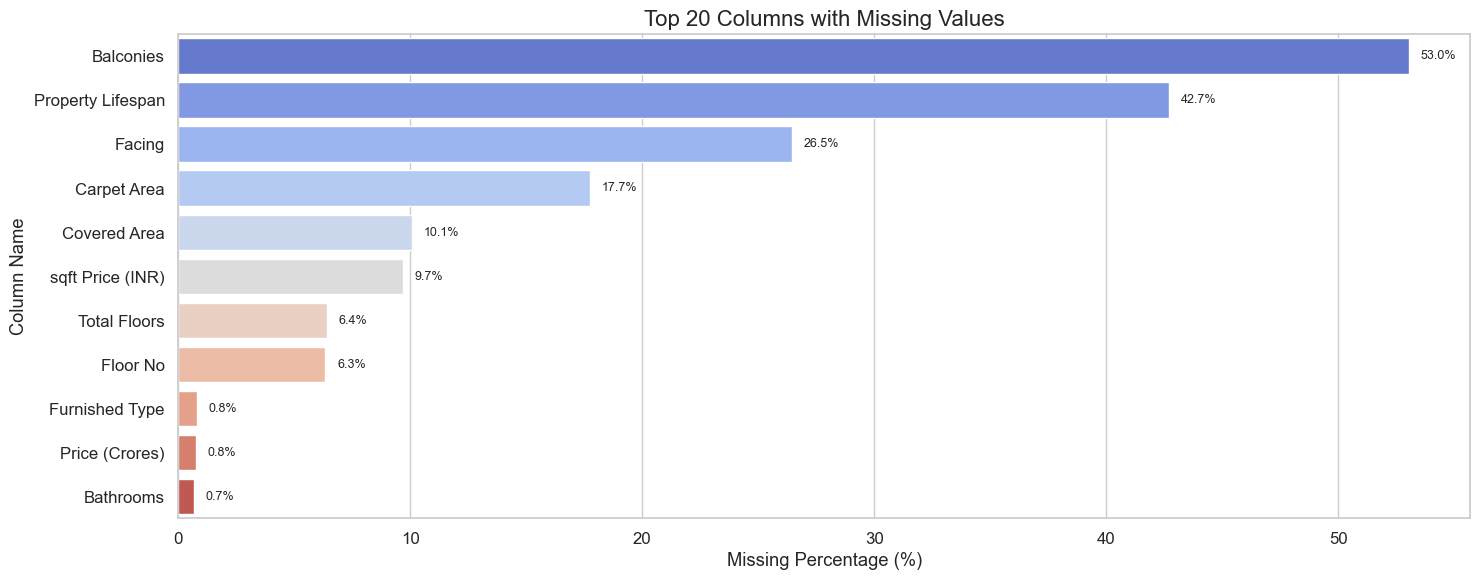

In [5]:
# Set Seaborn theme
sns.set(style="whitegrid", font_scale=1.1)

# Plot
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=missing_for_imputation, y='Column', x='Missing_Percentage', palette="coolwarm")

# Add value annotations to each bar
for i in ax.patches:
    plt.text(
        i.get_width() + 0.5,
        i.get_y() + i.get_height() / 2,
        f"{i.get_width():.1f}%",
        va='center',
        fontsize=9
    )

plt.title('Top 20 Columns with Missing Values', fontsize=16)
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Column Name')
plt.tight_layout()
plt.show()


##### Observations:
1- Balconies (53%) and Property Lifespan (42.70%) have very high missingness. \
2- Facing (26.5%), Carpet Area (17.7%), and Covered Area (10.1%) have moderate missingness. \
3- Other columns have lower missingness rates.

-------------

#### <b>Examine missing value patterns</b>

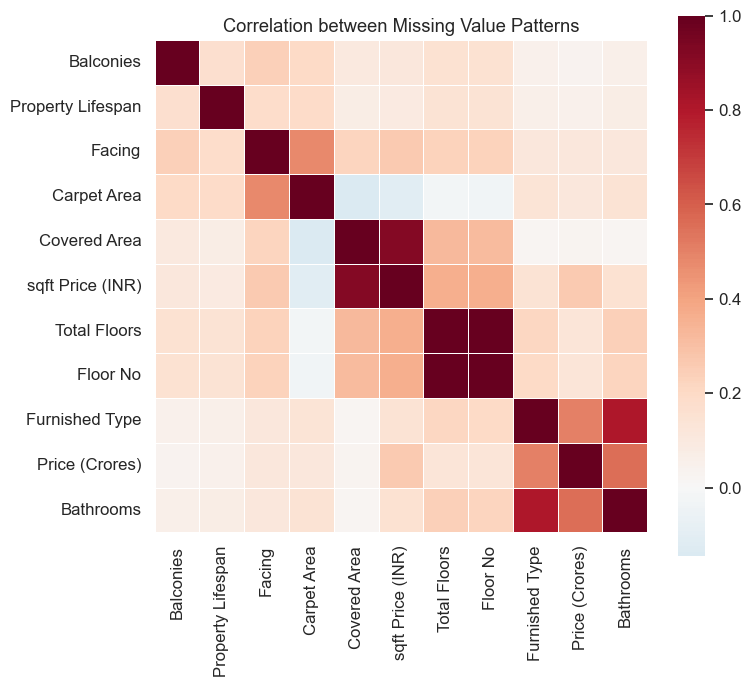

In [6]:
# Check if missing values have patterns i.e. whether two features tend to have missing values in the same rows.

# Create a missing value indicator matrix for columns with missing values
missing_matrix = df[missing_for_imputation['Column']].isnull().astype(int)

# Calculate correlation between missing patterns
missing_corr = missing_matrix.corr()
    
# Plot heatmap of missing value correlations
plt.figure(figsize=(8, 8))
sns.heatmap(missing_corr, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation between Missing Value Patterns')
plt.tight_layout()
plt.show()

##### Observation:
Missing pattern show correlations - some features tend to be missing together like (Covered Area, sqft Price), (Total Floors, Floor No), (Bathrooms, Furnished Type)

-----------

# <b>Missing values imputation</b>

#### Utilities

In [7]:
def plot_kde_comparison_diff_plot(*series, title="KDE Plot Comparison", figsize=(6, 4), palette="Set2"):
    """
    Plots seaborn KDE plots for multiple pandas Series side by side.
    
    Parameters:
    *series : pd.Series
        Variable number of pandas Series to plot.
    title : str
        Title for the entire figure.
    figsize : tuple
        Size of each subplot (width, height).
    palette : str
        Seaborn color palette.
    """
    num_series = len(series)
    total_figsize = (figsize[0] * num_series, figsize[1])  # Extend width based on number of plots

    plt.style.use('default')
    colors = sns.color_palette(palette, n_colors=num_series)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_series, figsize=total_figsize, sharey=True)
    if num_series == 1:
        axes = [axes]  # Ensure axes is always iterable

    # Plot each series in its subplot
    for i, (s, ax) in enumerate(zip(series, axes)):
        label = s.name if s.name else f"Series {i+1}"
        sns.kdeplot(data=s.dropna(), ax=ax, color=colors[i], linewidth=1.5, alpha=1)
        ax.set_title(label, fontsize=14, fontweight='bold')
        ax.set_xlabel("Value", fontsize=12)
        if i == 0:
            ax.set_ylabel("Density", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()

    return fig


In [8]:
def plot_kde_comparison_same_plot(*series, title="KDE Plot Comparison", figsize=(6, 5), palette="Set2"):
    """
    Plots seaborn KDE plots for multiple pandas Series on same plot.
    
    Parameters:

    df : pd.DataFrame
        The dataframe (can be used for context, though series are plotted directly)
    *series : pd.Series
        Variable number of pandas Series to plot
    title : str
        Title for the plot
    figsize : tuple
        Figure size (width, height)
    palette : str
        Color palette for the plots
    """
    
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette(palette)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot KDE for each series
    for i, s in enumerate(series):
        # Get series name or create default name
        label = s.name if s.name else f'Series {i+1}'
        
        # Plot KDE, handling missing values
        sns.kdeplot(data=s.dropna(), label=label, ax=ax, linewidth=1.5, alpha=1)
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    return fig


---------------

##### Price (Crores) <b>[Target Variable]</b>

In [9]:
# Total missing values
print(
    'Total number of listings with missing Price (Crores) value:',
    df['Price (Crores)'].isna().sum(),
    f"({round(df['Price (Crores)'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Price (Crores) value: 47 (0.75%)


In [10]:
# Store the values before imputation
before_imputation_price = df['Price (Crores)'].copy()

# Rename the series
before_imputation_price.name = 'Before Imputation'

In [11]:
# Properties having missing Price (Crores)
df_price_missing = df[df['Price (Crores)'].isna()]
df_price_missing.head()

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
141,Ready to Move,Immediately,2.0,Y,Madan Chikankar,NaN,NaN,600.0,Sai Samarth,NaN,NaN,Kalyan East,Sq-ft,Unfurnished,1.0,NaN,Resale,Apartment,Thane,1,Owner,5.0,N,Sq-ft,Less than 5 years,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.227853,73.132295,"Kalyan East, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan East
498,Under Construction,"Not Available, Contact Developer",9.0,Y,Versatile Housing,NaN,NaN,651.0,Versatile Valley,NaN,NaN,Dombivli East,Sq-ft,Unfurnished,1.0,NaN,Resale,Apartment,Thane,1,Owner,19.0,N,Sq-ft,NaN,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.211181,73.091129,"Dombivli East, Dombivli, Kalyan-Dombivli, Kaly...",Dombivli East
499,"Not Available, Contact Developer","Not Available, Contact Developer",4.0,N,Lodha,NaN,NaN,NaN,Lodha Codename Smart Buy,NaN,1987.0,Dombivli East,NaN,Semi-Furnished,3.0,NaN,Resale,Apartment,Thane,3,Owner,14.0,N,NaN,NaN,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.211181,73.091129,"Dombivli East, Dombivli, Kalyan-Dombivli, Kaly...",Dombivli East
1123,"Not Available, Contact Developer","Not Available, Contact Developer",NaN,N,Rustomjee,NaN,NaN,510.0,Global City,NaN,NaN,Virar West,Sq-ft,NaN,NaN,NaN,Resale,Apartment,Mumbai,2,Owner,NaN,Y,Sq-ft,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.054999,72.869203,"Mumbai Suburban, Maharashtra, India",Virar West
1124,"Not Available, Contact Developer","Not Available, Contact Developer",NaN,N,Vinay Unique Group,NaN,NaN,407.0,Vinay Unique Gardens,NaN,NaN,Virar West,Sq-ft,NaN,NaN,NaN,Resale,Apartment,

In [12]:
# Area-Bedrooms wise avg Property prices
df_sub = df.groupby(['Area', 'Bedrooms'])['Price (Crores)'].mean().reset_index()
df_sub

,Area,Bedrooms,Price (Crores)
0,4 Bunglows,1,1.300000
1,4 Bunglows,2,2.496667
2,4 Bunglows,4,14.250000
3,Aarey Milk Colony,1,0.320000
4,Agashi,3,0.500000
...,...,...,...
462,Waghbil,2,0.944167
463,Waghbil,3,1.787500
464,Wagle Industrial Estate,2,1.520000
465,Wagle Industrial Estate,3,1.875000


In [13]:
# Store index of df_price_missing 
df_price_missing = df_price_missing.reset_index()

# Drop the Price column
df_price_missing.drop(columns=['Price (Crores)'], inplace=True)

In [14]:
# Merge with df_sub
df_price_imputed = df_price_missing.merge(df_sub, how='left', on=['Area', 'Bedrooms'])

# Recover original index
df_price_imputed.index = df_price_imputed['index']

# Drop index column
df_price_imputed.drop(columns=['index'], inplace=True)

In [15]:
# Update original df
df.update(df_price_imputed)

In [16]:
# Store imputed Price (Crores) 
after_imputation_price = df['Price (Crores)'].copy()

# Rename the series
after_imputation_price.name = 'After Imputation'

Imputation quality check

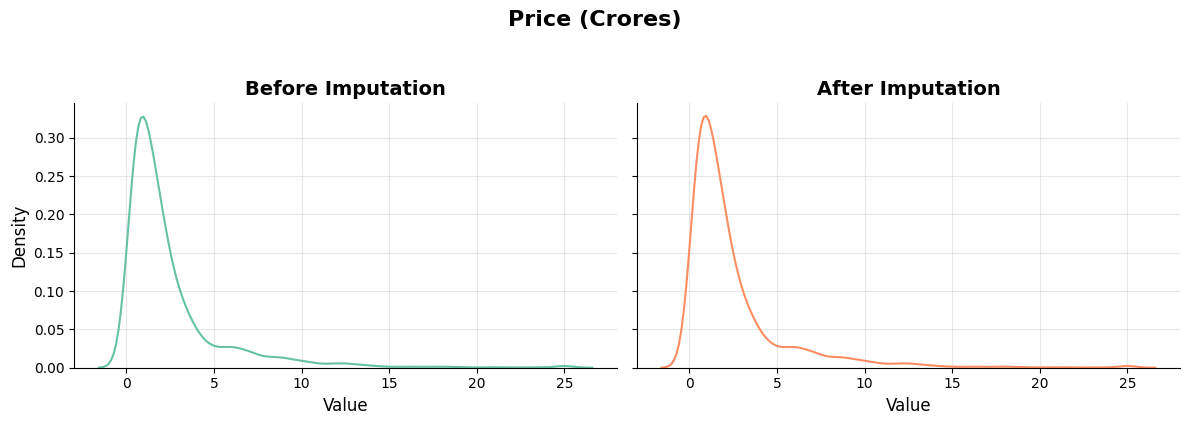

In [17]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_diff_plot(before_imputation_price, after_imputation_price, title='Price (Crores)')

In [18]:
# Two-sample KS-test for checking if before and after imputation distributions are statistically different
ks_stat, p_val_ks = ks_2samp(before_imputation_price.dropna(), after_imputation_price)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 1.0000


KS test: \
It's ideal for checking if imputed values resemble the original distribution. \
The KS test calculates the maximum vertical distance between the two CDFs being compared. A larger distance suggests that the distributions are different. The p-value then tells you the probability of observing such a large difference (or larger) if the null hypothesis (that the distributions are the same) were true. 

1- stat (D-statistic): Maximum vertical difference between the two ECDFs. \
2- p (p-value): Probability that the two samples come from the same distribution. \
3- Null hypothesis: The two distribution samples are drawn from the same continous distribution. \
3- Interpretation: 
- if p-value < 0.05: Statistically significant difference (reject Null). 
- if p-value > 0.05: No strong evidence to reject the null (they could be from same distribution)

As the distribution plots for before and after imputation completely overlap each other (Distribution match, shape similarity, variance preserved) and the ks test value is > 0.05, we can conclude that the Imputation preserved the structure and distribution of the original data well and the imputed values blend seamlessly with the original data.

-------------

##### Balconies

In [19]:
# Total missing values
print(
    'Total number of listings with missing Balconies value:',
    df['Balconies'].isna().sum(),
    f"({round(df['Balconies'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Balconies value: 3340 (53.04%)


In [20]:
# Store the values before
before_imputation_balconies = df['Balconies'].copy()

# Rename the series
before_imputation_balconies.name = 'Before Imputation'

##### Group based Fallback imputation for Balconies

In [21]:
# Strategy 1: Groups = Area-Society-Bedrooms-Bathrooms
df['Balconies'] = df['Balconies'].fillna(round(df.groupby(['Area', 'Society', 'Bedrooms', 'Bathrooms'])['Balconies'].transform('median')))
print('Missing values in Balconies after strategy 1 imputation: ', df['Balconies'].isnull().sum())

# Strategy 2: Groups = Broader_Area-Society-Bedrooms-Bathrooms
df['Balconies'] = df['Balconies'].fillna(round(df.groupby(['Area_Broader', 'Society', 'Bedrooms', 'Bathrooms'])['Balconies'].transform('median')))
print('Missing values in Balconies after strategy 2 imputation: ', df['Balconies'].isnull().sum())

# Strategy 3: Groups = Broader_Area-Bedrooms-Bathrooms
df['Balconies'] = df['Balconies'].fillna(round(df.groupby(['Area_Broader', 'Bedrooms', 'Bathrooms'])['Balconies'].transform('median')))
print('Missing values in Balconies after strategy 3 imputation: ', df['Balconies'].isnull().sum())

# Strategy 4: Groups = Bedrooms-Bathrooms
df['Balconies'] = df['Balconies'].fillna(round(df.groupby(['Bedrooms', 'Bathrooms'])['Balconies'].transform('median')))
print('Missing values in Balconies after strategy 4 imputation: ', df['Balconies'].isnull().sum())

# Strategy 5: Groups = Bedrooms only
df['Balconies'] = df['Balconies'].fillna(round(df.groupby(['Bedrooms'])['Balconies'].transform('median')))
print('Missing values in Balconies after strategy 5 imputation: ', df['Balconies'].isnull().sum())

Missing values in Balconies after strategy 1 imputation:  2154
Missing values in Balconies after strategy 2 imputation:  2154
Missing values in Balconies after strategy 3 imputation:  207
Missing values in Balconies after strategy 4 imputation:  39
Missing values in Balconies after strategy 5 imputation:  0


In [22]:
# Store values after Imputation
after_imputation_balconies = df['Balconies'].copy()

# Rename the series
after_imputation_balconies.name = 'After Imputation'

Imputation quality check

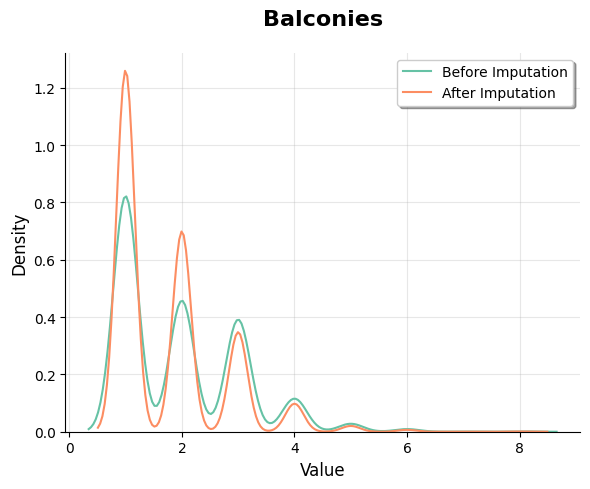

In [23]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_same_plot(before_imputation_balconies, after_imputation_balconies, title='Balconies')

In [24]:
# Two-sample KS-test for checking if before and after imputation distributions are statistically different
ks_stat, p_val_ks = ks_2samp(before_imputation_balconies.dropna(), after_imputation_balconies)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 0.0000


---------------

##### Covered area and Carpet area

In [25]:
# Total missing values
print(
    'Total number of listings with missing Covered area value:',
    df['Covered Area'].isna().sum(),
    f"({round(df['Covered Area'].isna().sum() / len(df) * 100, 2)}%)"
)

print(
    'Total number of listings with missing Carpet area value:',
    df['Carpet Area'].isna().sum(),
    f"({round(df['Carpet Area'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Covered area value: 636 (10.1%)
Total number of listings with missing Carpet area value: 1117 (17.74%)


In [26]:
# Store Covered area values before imputation
before_imputation_covered_area = df['Covered Area'].copy()

# Rename series
before_imputation_covered_area.name = 'Before Imputation'

# Store Carpet area values before imputation
before_imputation_carpet_area = df['Carpet Area'].copy()

# Rename series
before_imputation_carpet_area.name = 'Before Imputation'

In [27]:
# Listings where Carpet area is present but Covered area is missing
Carpet_present_Covered_missing = df[(df['Carpet Area'].notna()) & (df['Covered Area'].isna())]

In [28]:
# Listings where Carpet area is missing but Covered area is present
Carpet_missing_Covered_present = df[(df['Carpet Area'].isna()) & (df['Covered Area'].notna())]

In [29]:
# Area-Bedrooms-Bathrooms-Balconies wise average Covered and Carpet areas
df_sub = df.groupby(['Area', 'Bedrooms', 'Bathrooms', 'Balconies'])[['Covered Area', 'Carpet Area']].mean()

# Calculate avg Covered to Carpet area ratio
df_sub['avg_Covered_to_Carpet_ratio'] = df_sub['Covered Area'] / df_sub['Carpet Area']

In [30]:
# Reset Index
df_sub.reset_index(inplace=True)

# Display
df_sub

,Area,Bedrooms,Bathrooms,Balconies,Covered Area,Carpet Area,avg_Covered_to_Carpet_ratio
0,4 Bunglows,1,2.0,2.0,NaN,401.0,NaN
1,4 Bunglows,2,2.0,4.0,1400.0,915.0,1.530055
2,4 Bunglows,2,3.0,1.0,960.0,700.0,1.371429
3,4 Bunglows,4,4.0,2.0,3750.0,3200.0,1.171875
4,4 Bunglows,4,5.0,3.0,NaN,3192.0,NaN
...,...,...,...,...,...,...,...
1177,Wagle Industrial Estate,2,2.0,2.0,1000.0,786.0,1.272265
1178,Wagle Industrial Estate,3,2.0,3.0,1400.0,1000.0,1.400000
1179,Wagle Industrial Estate,3,3.0,1.0,1500.0,1100.0,1.363636
1180,Y K Nagar,1,1.0,3.0,750.0,450.0,1.666667


In [31]:
# Combinations where avg_Covered_to_Carpet_ratio is less than 1
df_sub[df_sub['avg_Covered_to_Carpet_ratio'] < 1]

,Area,Bedrooms,Bathrooms,Balconies,Covered Area,Carpet Area,avg_Covered_to_Carpet_ratio
156,Brhmanwada,2,2.0,1.0,653.000000,754.500000,0.865474
163,Charai,1,1.0,1.0,537.500000,560.000000,0.959821
213,Dadar East,3,3.0,3.0,1866.750000,1867.500000,0.999598
442,Kalina,2,2.0,1.0,947.333333,960.000000,0.986806
548,Khar West,4,3.0,2.0,1750.000000,1855.000000,0.943396
733,Matunga East,1,1.0,1.0,433.333333,470.000000,0.921986
783,Mumbai Central,3,2.0,3.0,1240.000000,1350.000000,0.918519
1046,Thane West,2,3.0,2.0,502.000000,577.333333,0.869515
1108,Vasant Vihar,2,2.0,1.0,825.000000,850.000000,0.970588


In [32]:
# Correct Covered area of these combinations

# Get IDs
idx =  df_sub[df_sub['avg_Covered_to_Carpet_ratio'] < 1].index

# Fix Covered area by multiplying Carpet area witha factor of 1.06
df_sub.loc[idx, 'Covered Area'] = df_sub.loc[idx, 'Carpet Area'] * 1.06

# Update avg_Covered_to_Carpet_ratio for these combinations
df_sub.loc[idx, 'avg_Covered_to_Carpet_ratio'] = df_sub.loc[idx, 'Covered Area'] / df_sub.loc[idx, 'Carpet Area']

# Check 
df_sub.loc[idx]

,Area,Bedrooms,Bathrooms,Balconies,Covered Area,Carpet Area,avg_Covered_to_Carpet_ratio
156,Brhmanwada,2,2.0,1.0,799.770000,754.500000,1.06
163,Charai,1,1.0,1.0,593.600000,560.000000,1.06
213,Dadar East,3,3.0,3.0,1979.550000,1867.500000,1.06
442,Kalina,2,2.0,1.0,1017.600000,960.000000,1.06
548,Khar West,4,3.0,2.0,1966.300000,1855.000000,1.06
733,Matunga East,1,1.0,1.0,498.200000,470.000000,1.06
783,Mumbai Central,3,2.0,3.0,1431.000000,1350.000000,1.06
1046,Thane West,2,3.0,2.0,611.973333,577.333333,1.06
1108,Vasant Vihar,2,2.0,1.0,901.000000,850.000000,1.06


In [33]:
# Listings where either of Covered area or Carpet area is missing
carpet_or_covered_missing = df[(df['Covered Area'].isna()) | (df['Carpet Area'].isna())]

# Store the index as column
carpet_or_covered_missing.reset_index(inplace=True)

In [34]:
# Merge with df_sub on Area-Bedrooms-Bathrooms-Balconies
carpet_or_covered_missing = carpet_or_covered_missing.merge(df_sub.drop(columns=['Covered Area', 'Carpet Area']), how='left', on=['Area', 'Bedrooms', 'Bathrooms', 'Balconies'])

# Restore the original index
carpet_or_covered_missing.index = carpet_or_covered_missing['index']

# Drop index column
carpet_or_covered_missing.drop(columns=['index'], inplace=True)

In [35]:
# IDs of listings where Covered area is missing but Carpet area & avg_Covered_to_Carpet_ratio is present
idx = carpet_or_covered_missing[(carpet_or_covered_missing['Covered Area'].isna()) & (carpet_or_covered_missing['Carpet Area'].notna()) & (carpet_or_covered_missing['avg_Covered_to_Carpet_ratio'].notna())].index

# Impute Covered area for these IDs
carpet_or_covered_missing.loc[idx, 'Covered Area'] = carpet_or_covered_missing.loc[idx, 'Carpet Area'] * carpet_or_covered_missing.loc[idx, 'avg_Covered_to_Carpet_ratio']

# Update sqft Price for these listings
carpet_or_covered_missing.loc[idx, 'sqft Price (INR)'] = (carpet_or_covered_missing.loc[idx, 'Price (Crores)'] * 10000000) / carpet_or_covered_missing.loc[idx, 'Covered Area'] 

# Update Unit of Covered area for these listings
carpet_or_covered_missing.loc[idx, 'Unit of Covered Area'] = 'Sq-ft'

In [36]:
# IDs of listings where Carpet area is missing but Covered area & avg_Covered_to_Carpet_ratio is present
idx = carpet_or_covered_missing[(carpet_or_covered_missing['Covered Area'].notna()) & (carpet_or_covered_missing['Carpet Area'].isna()) & (carpet_or_covered_missing['avg_Covered_to_Carpet_ratio'].notna())].index

# Impute Carpet area for these IDs
carpet_or_covered_missing.loc[idx, 'Carpet Area'] = carpet_or_covered_missing.loc[idx, 'Covered Area'] / carpet_or_covered_missing.loc[idx, 'avg_Covered_to_Carpet_ratio']

# Update Unit of Carpet area for these listings
carpet_or_covered_missing.loc[idx, 'Unit of Carpet Area'] = 'Sq-ft'

In [37]:
# Only covered area missing listings

# Get IDs
idx = carpet_or_covered_missing[carpet_or_covered_missing['Covered Area'].isna()].index

# Impute Covered area by multiplying Carpet area with global Covered to Carpet area ratio
carpet_or_covered_missing.loc[idx, 'Covered Area'] = carpet_or_covered_missing.loc[idx, 'Carpet Area'] * (df['Covered Area'].median() / df['Carpet Area'].median())

# Update sqft Price for these listings
carpet_or_covered_missing.loc[idx, 'sqft Price (INR)'] = (carpet_or_covered_missing.loc[idx, 'Price (Crores)'] * 10000000) / carpet_or_covered_missing.loc[idx, 'Covered Area'] 

# Update Unit of Covered area for these listings
carpet_or_covered_missing.loc[idx, 'Unit of Covered Area'] = 'Sq-ft'

In [38]:
# Only carpet area missing listings

# Get IDs
idx = carpet_or_covered_missing[carpet_or_covered_missing['Carpet Area'].isna()].index

# Impute Carpet area by multiplying Covered area with global Carpet to Covered area ratio
carpet_or_covered_missing.loc[idx, 'Carpet Area'] = carpet_or_covered_missing.loc[idx, 'Covered Area'] * (df['Carpet Area'].median() / df['Covered Area'].median())

# Update Unit of Carpet area for these listings
carpet_or_covered_missing.loc[idx, 'Unit of Carpet Area'] = 'Sq-ft'

In [39]:
# Update original dataframe
df.update(carpet_or_covered_missing)

In [40]:
# Property listings where either Covered area or Carpet area is missing

# Get IDs
idx = df[(df['Covered Area'].isna()) | (df['Carpet Area'].isna())].index

# Drop these listings permanently
df.drop(index=idx, inplace=True)

print('Number of listings dropped: ', len(idx))

Number of listings dropped:  7


In [41]:
# Verify

# Check missing values in Covered area
print('Missing values in Covered area: ', df['Covered Area'].isna().sum())

# Check missing values in Carpet area
print('Missing values in Carpet area: ', df['Carpet Area'].isna().sum())

Missing values in Covered area:  0
Missing values in Carpet area:  0


##### Property listings where Covered area is not greater than the Carpet area [Inaccurate]

In [42]:
# Construct dataframe of properties where Covered is not greater than the carpet area
df_inaccurate = df[~(df['Covered Area'] > df['Carpet Area'])]
df_inaccurate.shape[0]

418

In [43]:
# Preserve index as column
df_inaccurate.reset_index(inplace=True)

In [44]:
# Accurate listings having Covered Area greater than the Carpet area
df_sub = df[df['Covered Area'] > df['Carpet Area']]

# Get average Covered area to Carpet area ratio Society-Bedrooms-Balconies wise
SBB_wise_covered_carpet_areas_df = df_sub.groupby(['Society', 'Bedrooms', 'Balconies'])[['Covered Area', 'Carpet Area']].mean()
SBB_wise_covered_carpet_areas_df['Covered_to_Carpet_ratio'] = SBB_wise_covered_carpet_areas_df['Covered Area'] / SBB_wise_covered_carpet_areas_df['Carpet Area']

# Reset Index
SBB_wise_covered_carpet_areas_df.reset_index(inplace=True)

# Display
SBB_wise_covered_carpet_areas_df

,Society,Bedrooms,Balconies,Covered Area,Carpet Area,Covered_to_Carpet_ratio
0,10 Central Avenue,2,2.0,855.263158,650.000000,1.315789
1,111 Hyde Park,2,2.0,1250.000000,700.000000,1.785714
2,127 Raj Home,1,2.0,646.000000,449.000000,1.438753
3,127 Raj Home,1,3.0,752.857143,460.142857,1.636138
4,127 Raj Home,2,3.0,1050.000000,653.000000,1.607963
...,...,...,...,...,...,...
3543,Yogi Dham Phase Iii,1,2.0,695.000000,487.252929,1.426364
3544,Yogi Dham Phase Iii,2,1.0,980.000000,685.000000,1.430657
3545,Zee Heights,1,1.0,271.729963,234.647231,1.158036
3546,Zinnia,3,1.0,1378.000000,950.000000,1.450526


In [45]:
# Merge df_inaccurate with SBB_wise_covered_carpet_areas_df
df_inaccurate = df_inaccurate.merge(SBB_wise_covered_carpet_areas_df.drop(columns=['Covered Area', 'Carpet Area']), how='left', on=['Society', 'Bedrooms', 'Balconies'])

# Update Covered area of these listings where Covered_to_Carpet_ratio is not null
idx = df_inaccurate[df_inaccurate['Covered_to_Carpet_ratio'].notna()].index

df_inaccurate.loc[idx, 'Covered Area'] = df_inaccurate.loc[idx, 'Carpet Area'] * df_inaccurate.loc[idx, 'Covered_to_Carpet_ratio']


In [46]:
# Update sqft Price of these listings
df_inaccurate.loc[idx, 'sqft Price (INR)'] = (df_inaccurate.loc[idx, 'Price (Crores)'] * 10000000) / df_inaccurate.loc[idx, 'Covered Area']

In [47]:
# Restore original index
df_inaccurate.index = df_inaccurate['index']

# Drop index column
df_inaccurate.drop(columns=['index'], inplace=True)

In [48]:
# For listing still having Covered area not greater than Carpet area

# Get IDs
idx = df_inaccurate[df_inaccurate['Covered Area'] == df_inaccurate['Carpet Area']].index

# Update
df_inaccurate.loc[idx, 'Covered Area'] = df_inaccurate.loc[idx, 'Carpet Area'] * 1.25

# Update sqft Price of these listings
df_inaccurate.loc[idx, 'sqft Price (INR)'] = (df_inaccurate.loc[idx, 'Price (Crores)'] * 10000000) / df_inaccurate.loc[idx, 'Covered Area']

In [49]:
# Update original df
df.update(df_inaccurate)

In [50]:
# Store imputed Covered area
after_imputation_covered_area = df['Covered Area'].copy()

# Rename the series
after_imputation_covered_area.name = 'After Imputation'

# Store imputed Carpet area
after_imputation_carpet_area = df['Carpet Area'].copy()

# Rename the series
after_imputation_carpet_area.name = 'After Imputation'


Imputation quality check for Covered area

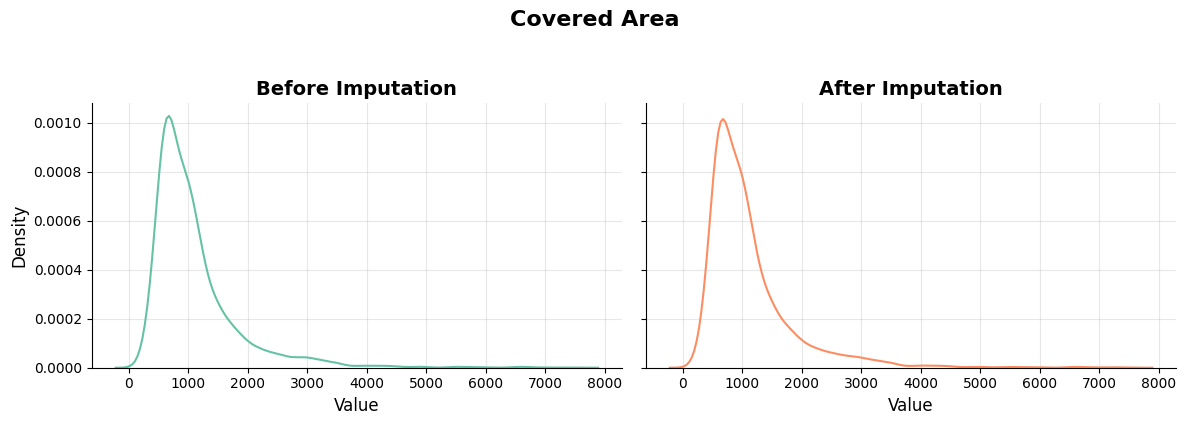

In [51]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_diff_plot(before_imputation_covered_area, after_imputation_covered_area, title='Covered Area')

In [52]:
# Two-sample KS test for Covered area imputation
ks_stat, p_val_ks = ks_2samp(before_imputation_covered_area.dropna(), after_imputation_covered_area)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 0.4030


As the distribution plots for before and after imputation mostly overlap each other (Distribution match, shape similarity, variance preserved) and the ks test value is > 0.05, we can conclude that the Imputation preserved the structure and distribution of the original data well and the imputed values blend seamlessly with the original data.

Imputation quality check for Carpet area

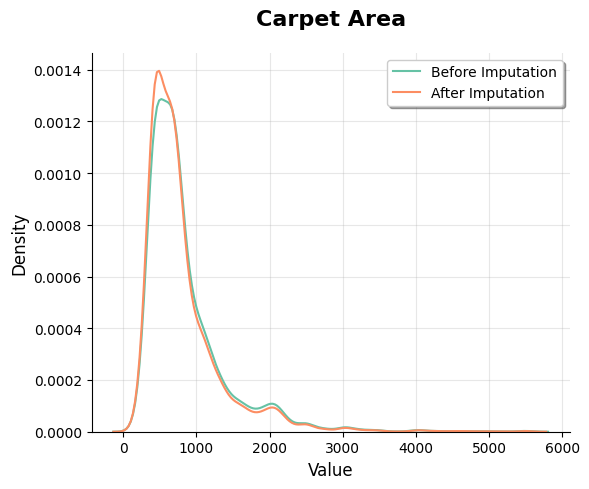

In [53]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_same_plot(before_imputation_carpet_area, after_imputation_carpet_area, title='Carpet Area')

In [54]:
# Two-sample KS test for Carpet area imputation
ks_stat, p_val_ks = ks_2samp(before_imputation_carpet_area.dropna(), after_imputation_carpet_area)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 0.0001


-------------------

#### Unit of Covered Area and Unit of Carpet Area

In [55]:
# Total missing values
print(
    'Total number of listings with missing Unit of Covered Area value:',
    df['Unit of Covered Area'].isna().sum(),
    f"({round(df['Unit of Covered Area'].isna().sum() / len(df) * 100, 2)}%)"
)

print(
    'Total number of listings with missing Unit of Carpet Area value:',
    df['Unit of Carpet Area'].isna().sum(),
    f"({round(df['Unit of Carpet Area'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Unit of Covered Area value: 17 (0.27%)
Total number of listings with missing Unit of Carpet Area value: 645 (10.25%)


In [56]:
# Listings where 'Unit of Covered Area' is missing
df[df['Unit of Covered Area'].isna()].sample(4)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
4212,Ready to Move,Immediately,0.0,N,Sheth Creators & Ym Infra,4.800,Marine lines station.,1142.105263,One Marina,42027.649770,868.0,Marine Lines,NaN,Unfurnished,2.0,NaN,New Property,Apartment,Mumbai,2,Agent,70.0,Y,NaN,NaN,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.054999,72.869203,"Mumbai Suburban, Maharashtra, India",Marine Lines
3333,Ready to Move,Immediately,4.0,N,Hubtown Ltd.,13.915,Opp siddhivinayak temple,2039.473684,25 South,68228.387097,1550.0,Prabhadevi,NaN,Unfurnished,3.0,West,New Property,Apartment,Mumbai,3,Agent,47.0,Y,NaN,NaN,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.007472,72.835897,"Prabhadevi, MTHL - Worli Connector, Kamgar Nag...",Prabhadevi
3008,Ready to Move,Immediately,62.0,N,Bombay Realty,10.700,"Very near from monorail station, eastern highw...",2823.684211,Bombay Dyeing Two Icc,37893.755825,2146.0,Dadar East,NaN,Unfurnished,5.0,West,Resale,Apartment,Mumbai,4,Owner,63.0,Y,NaN,Less than 5 years,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.017810,72.847802,"Khodadad Circle, Jagannath Nana Shankar Sheth ...",Dadar East
3289,Ready to Move,Immediately,4.0,Y,Aristo Realty Developers Ltd.,10.400,Ravindra natya mandir prabhadevi.,2894.736842,Aristo Pearl Residency,35927.272727,2200.0,Prabhadevi,NaN,Unfurnished,5.0,East,Resale,Apartment,Mumbai,5,Agent,27.0,Y,NaN,5 to 10 years,2.0,1,1,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.007472,72.835897,"Prabhadevi, MTHL - Worli Connector, Kamgar Nag...",Prabhadevi


Manual inspection reveals all these listings have Covered area in sq-ft.

In [57]:
# Get IDs of these listings
idx = df[df['Unit of Covered Area'].isna()].index

# Update 'Unit of Covered Area' to 'Sq-ft'
df.loc[idx, 'Unit of Covered Area'] = 'Sq-ft'

In [58]:
# Listings where 'Unit of Carpet Area' is missing
df_sub = df[df['Unit of Carpet Area'].isna()]
print('Number of listings with missing Unit of Carpet area is: ', len(df_sub))
print()
print('Sample:')
# Sample
df_sub.sample(5)

Number of listings with missing Unit of Carpet area is:  645

Sample:


,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
4842,Ready to Move,Immediately,4.0,Y,Hill Group,0.9200,Near charkop police station,673.649049,Hill View,13656.962804,480.0,Kandivali West,NaN,Semi-Furnished,2.0,East,Resale,Apartment,Mumbai,1,Agent,7.0,Y,Sq-ft,15 to 20 years,2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.216097,72.814769,"Charkop Sector 8, R/C Ward, Zone 4, Mumbai Sub...",Kandivali West
650,Ready to Move,Immediately,2.0,N,Bajrang Infra,0.4400,Near guardian school,1040.471491,Shivam Apartments,4228.852052,780.0,Dombivli East,NaN,Unfurnished,2.0,NaN,Resale,Apartment,Thane,2,Owner,7.0,Y,Sq-ft,5 to 10 years,2.0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.211181,73.091129,"Dombivli East, Dombivli, Kalyan-Dombivli, Kaly...",Dombivli East
5115,Ready to Move,Immediately,4.0,Y,Lokhandwala Construction Industries Pvt. Ltd.,0.6800,"Lokhandwala school, parks, hospital, gym and m...",397.006130,Lokhandwala Spring Leaf,17128.199012,300.0,Kandivali East,NaN,Semi-Furnished,1.0,East,Resale,Apartment,Mumbai,1,Owner,7.0,N,Sq-ft,Above 20 years,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.198314,72.860647,"Akurli, Western Express Highway, Kandivali Eas...",Kandivali East
2799,Under Construction,Jun 26,NaN,Y,Dosti Realty,2.0100,NaN,770.136109,Dosti Mezzo 22,26099.282657,602.0,Sion Koliwada,NaN,Unfurnished,2.0,NaN,New Property,Apartment,Mumbai,2,Agent,NaN,Y,Sq-ft,NaN,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.042815,72.865356,"Sion East, F/N Ward, Zone 2, Mumbai City, Maha...",Sion Koliwada
2009,Ready to Move,Immediately,NaN,N,Raunak

In [59]:
# Stats of 'Carpet Area' for these listings
print('----------------------Stats of Carpet area for listings with missing Unit of Carpet area-----------------------')
print(df_sub['Carpet Area'].describe())
print()

print('----------------------Stats of Bedrooms for listings with missing Unit of Carpet area--------------------------')
print(df_sub['Bedrooms'].describe())
print()

print('----------------------Count of Bedrooms for listings with missing Unit of Carpet area--------------------------')
print(df_sub['Bedrooms'].value_counts())

----------------------Stats of Carpet area for listings with missing Unit of Carpet area-----------------------
count     645.000000
mean      819.150388
std       590.276281
min       169.000000
25%       452.000000
50%       645.000000
75%       944.000000
max      5500.000000
Name: Carpet Area, dtype: float64

----------------------Stats of Bedrooms for listings with missing Unit of Carpet area--------------------------
count    645.00000
mean       2.03876
std        1.03362
min        1.00000
25%        1.00000
50%        2.00000
75%        3.00000
max        6.00000
Name: Bedrooms, dtype: float64

----------------------Count of Bedrooms for listings with missing Unit of Carpet area--------------------------
Bedrooms
2    239
1    229
3    122
4     37
5     14
6      4
Name: count, dtype: int64


Above analysis reveals that the Carpet area of these listings is in 'Sq-ft'

In [60]:
# Get IDs of these listings
idx = df_sub.index

# Update the 'Unit of Carpet Area' to 'Sq-ft'
df.loc[idx, 'Unit of Carpet Area'] = 'Sq-ft'

In [61]:
# Verify
print("Number of missing values in 'Unit of Covered Area': ", df['Unit of Covered Area'].isna().sum())
print("Number of missing values in 'Unit of Carpet Area': ", df['Unit of Carpet Area'].isna().sum())

Number of missing values in 'Unit of Covered Area':  0
Number of missing values in 'Unit of Carpet Area':  0


---------------------

##### sqft Price (INR)

In [62]:
# Total missing values
print(
    'Total number of listings with missing sqft Price (INR) value:',
    df['sqft Price (INR)'].isna().sum(),
    f"({round(df['sqft Price (INR)'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing sqft Price (INR) value: 36 (0.57%)


In [63]:
# Construct dataframe for listings with missing sqft Price
sqft_missing_df = df[df['sqft Price (INR)'].isna()]

In [64]:
# Impute missing values (Rule based)
sqft_missing_df['sqft Price (INR)'] = (sqft_missing_df['Price (Crores)'] * 10000000) / sqft_missing_df['Covered Area'] 

# Update original df
df.update(sqft_missing_df)


In [65]:
# Verify
print('Missing values in sqft Price (INR):', df['sqft Price (INR)'].isna().sum())

Missing values in sqft Price (INR): 0


----------

#### Floor No and Total Floors

In [66]:
# Total missing values
print(
    'Total number of listings with missing Total Floors value:',
    df['Total Floors'].isna().sum(),
    f"({round(df['Total Floors'].isna().sum() / len(df) * 100, 2)}%)"
)

print(
    'Total number of listings with missing Floor No value:',
    df['Floor No'].isna().sum(),
    f"({round(df['Floor No'].isna().sum() / len(df) * 100, 2)}%)"
)


Total number of listings with missing Total Floors value: 403 (6.41%)
Total number of listings with missing Floor No value: 399 (6.34%)


In [67]:
# Store Total Floors values before imputation
before_imputation_total_floors = df['Total Floors'].copy()

# Rename the series
before_imputation_total_floors.name = 'Before Imputation'

# Store Floor No values before imputation
before_imputation_floor_no = df['Floor No'].copy()

# Rename the series
before_imputation_floor_no.name = 'Before Imputation'

In [68]:
# Listings where both are missing
print('Number of Listings where both the Floor No and Total Floors are missing together: ', len(df[(df['Floor No'].isna()) & (df['Total Floors'].isna())]))

Number of Listings where both the Floor No and Total Floors are missing together:  399


In [69]:
# Impute 'Total Floors' using hierarchical group-wise median imputation

# Calculate medians at different grouping levels
total_floors_median_CADTwise = df.groupby(['City', 'Area', 'Developer', 'Type of Property'])['Total Floors'].median()
total_floors_median_CATwise = df.groupby(['City', 'Area', 'Type of Property'])['Total Floors'].median()
total_floors_median_CTwise = df.groupby(['City', 'Type of Property'])['Total Floors'].median()
total_floors_median_Twise = df.groupby(['Type of Property'])['Total Floors'].median()

for idx, row in df[df['Total Floors'].isnull()].iterrows():
    key1 = (row['City'], row['Area'], row['Developer'], row['Type of Property'])
    key2 = (row['City'], row['Area'], row['Type of Property'])
    key3 = (row['City'], row['Type of Property'])
    key4 = row['Type of Property']

    if key1 in total_floors_median_CADTwise and pd.notna(total_floors_median_CADTwise[key1]):
        df.at[idx, 'Total Floors'] = round(total_floors_median_CADTwise[key1])
    elif key2 in total_floors_median_CATwise and pd.notna(total_floors_median_CATwise[key2]):
        df.at[idx, 'Total Floors'] = round(total_floors_median_CATwise[key2])
    elif key3 in total_floors_median_CTwise and pd.notna(total_floors_median_CTwise[key3]):
        df.at[idx, 'Total Floors'] = round(total_floors_median_CTwise[key3])
    elif key4 in total_floors_median_Twise and pd.notna(total_floors_median_Twise[key4]):
        df.at[idx, 'Total Floors'] = round(total_floors_median_Twise[key4])
    else:
        # Fallback to overall median if none of the above groups have median
        df.at[idx, 'Total Floors'] = round(df['Total Floors'].median())

In [70]:
# Impute 'Floor No' using hierarchical group-wise median imputation

# Calculate medians at different grouping levels for 'Floor No'
floor_no_median_CADTwise = df.groupby(['City', 'Area', 'Developer', 'Type of Property'])['Floor No'].median()
floor_no_median_CATwise = df.groupby(['City', 'Area', 'Type of Property'])['Floor No'].median()
floor_no_median_CTwise = df.groupby(['City', 'Type of Property'])['Floor No'].median()
floor_no_median_Twise = df.groupby(['Type of Property'])['Floor No'].median()

for idx, row in df[df['Floor No'].isnull()].iterrows():
    key1 = (row['City'], row['Area'], row['Developer'], row['Type of Property'])
    key2 = (row['City'], row['Area'], row['Type of Property'])
    key3 = (row['City'], row['Type of Property'])
    key4 = row['Type of Property']

    if key1 in floor_no_median_CADTwise and pd.notna(floor_no_median_CADTwise[key1]):
        df.at[idx, 'Floor No'] = floor_no_median_CADTwise[key1]
    elif key2 in floor_no_median_CATwise and pd.notna(floor_no_median_CATwise[key2]):
        df.at[idx, 'Floor No'] = floor_no_median_CATwise[key2]
    elif key3 in floor_no_median_CTwise and pd.notna(floor_no_median_CTwise[key3]):
        df.at[idx, 'Floor No'] = floor_no_median_CTwise[key3]
    elif key4 in floor_no_median_Twise and pd.notna(floor_no_median_Twise[key4]):
        df.at[idx, 'Floor No'] = floor_no_median_Twise[key4]
    else:
        # Fallback to overall median if none of the above groups have median
        df.at[idx, 'Floor No'] = df['Floor No'].median()

In [71]:
# Validate that Floor No is lesser than Total Floors for all the listings

# Listing having Floor No greater than Total Floors
df[df['Floor No'] > df['Total Floors']]

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
4481,Ready to Move,Immediately,24.0,N,Shristi Infrastructure Development Corporation...,7.5,NaN,2200.0,Shristi Sea View,34091.0,1672.0,Asavari,Sq-ft,NaN,3.0,NaN,Resale,Apartment,Mumbai,3,Owner,20.0,N,Sq-ft,NaN,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.054999,72.869203,"Mumbai Suburban, Maharashtra, India",Mahim


In [72]:
# Correct by choosing a random number between 1 and 20
df.loc[4481, 'Floor No'] = np.random.randint(1, 21)


In [73]:
# Verify
print('Total number of listings with missing Total Floors: ', df['Total Floors'].isna().sum())
print('Total number of listings with missing Floor No: ', df['Floor No'].isna().sum())

Total number of listings with missing Total Floors:  0
Total number of listings with missing Floor No:  0


In [74]:
# Store imputed Total Floors
after_imputation_total_floors = df['Total Floors'].copy()

# Rename the series
after_imputation_total_floors.name = 'After Imputation'

# Store imputed Floor No
after_imputation_floor_no = df['Floor No'].copy()

# Rename the series
after_imputation_floor_no.name = 'After Imputation'

Imputation quality check for Total Floors

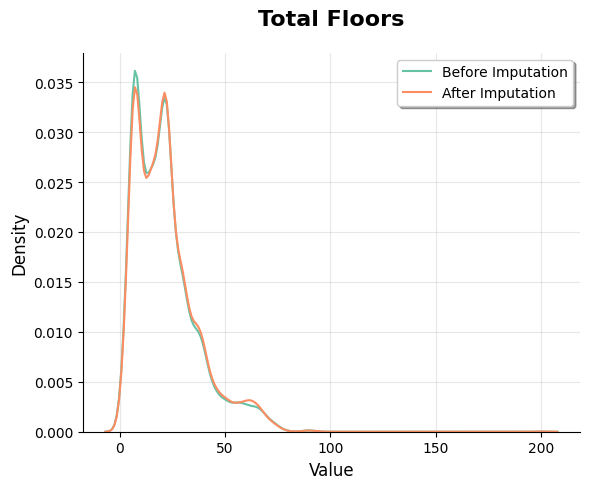

In [75]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_same_plot(before_imputation_total_floors, after_imputation_total_floors, title='Total Floors')

In [76]:
# Two-sample KS test for Total Floors imputation
ks_stat, p_val_ks = ks_2samp(before_imputation_total_floors.dropna(), after_imputation_total_floors)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 0.4121


As the distribution plots for before and after imputation mostly overlap each other (Distribution match, shape similarity, variance preserved) and the ks test value is > 0.05, we can conclude that the Imputation preserved the structure and distribution of the original data well and the imputed values blend seamlessly with the original data.

Imputation quality check for Floor No

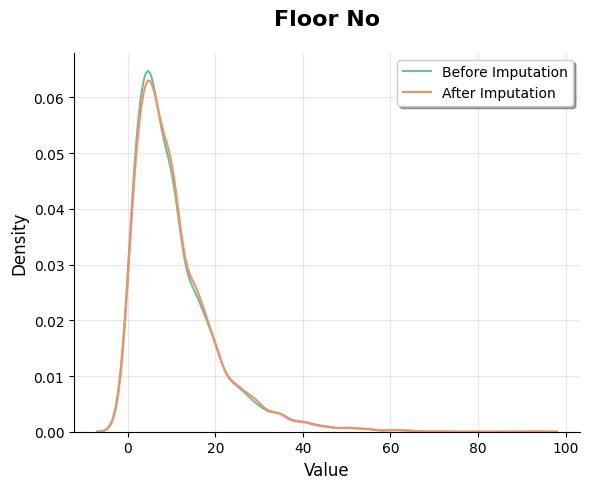

In [77]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_same_plot(before_imputation_floor_no, after_imputation_floor_no, title='Floor No')

In [78]:
# Two-sample KS test for Floor No imputation
ks_stat, p_val_ks = ks_2samp(before_imputation_floor_no.dropna(), after_imputation_floor_no)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 0.3265


As the distribution plots for before and after imputation mostly overlap each other (Distribution match, shape similarity, variance preserved) and the ks test value is > 0.05, we can conclude that the Imputation preserved the structure and distribution of the original data well and the imputed values blend seamlessly with the original data.

--------------

#### Furnished Type

In [79]:
# Total missing values
print(
    'Total number of listings with missing Furnished Type value:',
    df['Furnished Type'].isna().sum(),
    f"({round(df['Furnished Type'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Furnished Type value: 46 (0.73%)


In [80]:
# Count unique values
df['Furnished Type'].value_counts()

Furnished Type
Unfurnished       3419
Semi-Furnished    1987
Furnished          838
Name: count, dtype: int64

In [81]:
# Impute missing Furnished Type values using the Mode imputation
df['Furnished Type'].fillna(df['Furnished Type'].mode()[0], inplace=True)

In [82]:
# Verify
print('Total Number of listings with missing Furnished Type: ', df['Furnished Type'].isna().sum())

Total Number of listings with missing Furnished Type:  0


------------------

#### Bathrooms

In [83]:
# Total missing values
print(
    'Total number of listings with missing Bathrooms value:',
    df['Bathrooms'].isna().sum(),
    f"({round(df['Bathrooms'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Bathrooms value: 38 (0.6%)


In [84]:
# Store values before imputation
before_imputation_bathrooms = df['Bathrooms'].copy()

# Rename the series
before_imputation_bathrooms.name = 'Before Imputation'

In [85]:
# Stats of Bathrooms
df['Bathrooms'].describe()

count    6252.000000
mean        2.238324
std         0.937744
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: Bathrooms, dtype: float64

In [86]:
# Impute missing Furnished Type values using the Median imputation
df['Bathrooms'].fillna(round(df['Bathrooms'].median()), inplace=True)

In [87]:
# Store imputed values
after_imputation_bathrooms = df['Bathrooms'].copy()

# Rename the series
after_imputation_bathrooms.name = 'After Imputation'

Imputation quality check

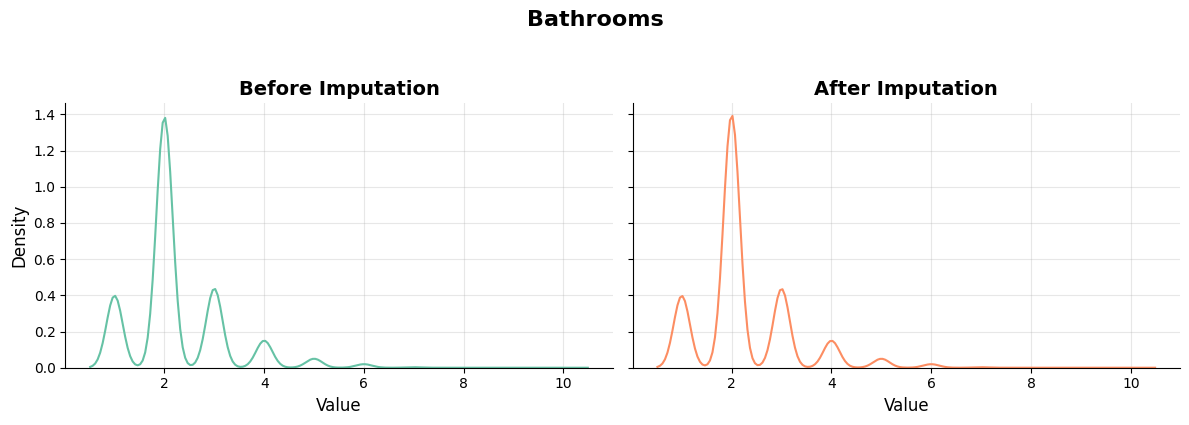

In [88]:
# Plot distribution plot before and after imputation
fig = plot_kde_comparison_diff_plot(before_imputation_bathrooms, after_imputation_bathrooms, title='Bathrooms')

In [89]:
# Two-sample KS test for Floor No imputation
ks_stat, p_val_ks = ks_2samp(before_imputation_bathrooms.dropna(), after_imputation_bathrooms)
print(f"KS-test p-value: {p_val_ks:.4f}")

KS-test p-value: 1.0000


As the distribution plots for before and after imputation completely overlap each other (Distribution match, shape similarity, variance preserved) and the ks test value is > 0.05, we can conclude that the Imputation preserved the structure and distribution of the original data well and the imputed values blend seamlessly with the original data.

------------

#### Property Lifespan

In [90]:
# Total missing values
print(
    'Total number of listings with missing Property Lifespan value:',
    df['Property Lifespan'].isna().sum(),
    f"({round(df['Property Lifespan'].isna().sum() / len(df) * 100, 2)}%)"
)


Total number of listings with missing Property Lifespan value: 2686 (42.7%)


In [91]:
# Count unique values
df['Property Lifespan'].value_counts()

Property Lifespan
New construction     1062
Less than 5 years     821
5 to 10 years         769
10 to 15 years        466
Above 20 years        249
15 to 20 years        237
Name: count, dtype: int64

In [ ]:
# Transaction type of properties with missing Lifespan
df[df['Property Lifespan'].isna()]['Transaction Type'].value_counts()

Transaction Type
New Property    1758
Resale           928
Name: count, dtype: int64

Impute Lifespan of properties with 'New Property' transaction type:

In [ ]:
# Property Lifespan of 'New Property' transaction type properties
df[df['Transaction Type'] == 'New Property']['Property Lifespan'].value_counts()

Property Lifespan
New construction     519
Less than 5 years    110
5 to 10 years         33
10 to 15 years        16
15 to 20 years         7
Above 20 years         6
Name: count, dtype: int64

Group-based imputation using Price bins:
- Bin the price column into categories (e.g., low, medium, high).

- Within each price bin, calculate the distribution of property lifespans for resale properties.

- Impute missing lifespans by sampling according to the distribution within the same price bin.

In [ ]:
# Create price bins
df['Price_bin'] = pd.qcut(df['Price (Crores)'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [138]:
# Property lifespan distribution for each price bin in 'New Property' properties
df[df['Transaction Type'] == 'New Property'].groupby('Price_bin')['Property Lifespan'].value_counts(normalize=True)

Price_bin  Property Lifespan
Low        New construction     0.733558
           Less than 5 years    0.177066
           5 to 10 years        0.065767
           15 to 20 years       0.015177
           10 to 15 years       0.008432
           Above 20 years       0.000000
Medium     New construction     0.746503
           Less than 5 years    0.180070
           5 to 10 years        0.038462
           Above 20 years       0.013986
           10 to 15 years       0.010490
           15 to 20 years       0.010490
High       New construction     0.755070
           Less than 5 years    0.104524
           10 to 15 years       0.063963
           5 to 10 years        0.049922
           Above 20 years       0.015601
           15 to 20 years       0.010920
Very High  New construction     0.738725
           Less than 5 years    0.161742
           5 to 10 years        0.055988
           10 to 15 years       0.020218
           Above 20 years       0.017107
           15 to 20 years   

In [ ]:
# For each price bin, calculate lifespan distribution for 'New Property' properties
lifespan_dist_by_price_for_new_properties = df[df['Transaction Type'] == 'New Property'].groupby('Price_bin')['Property Lifespan'].value_counts(normalize=True)

# Find missing indices in 'New Property' properties
missing_idx = df[(df['Property Lifespan'].isna()) & (df['Transaction Type'] == 'New Property')].index

for idx in missing_idx:
    price_bin = df.loc[idx, 'Price_bin']
    dist = lifespan_dist_by_price_for_new_properties[price_bin]

    # Sample one category based on distribution in this price bin
    imputed_value = np.random.choice(dist.index, p=dist.values)
    df.at[idx, 'Property Lifespan'] = imputed_value

In [122]:
# After Imputation: Property Lifespan of 'New Property' transaction type properties
df[df['Transaction Type'] == 'New Property']['Property Lifespan'].value_counts()

Property Lifespan
New construction     1821
Less than 5 years     379
5 to 10 years         129
10 to 15 years         65
Above 20 years         29
15 to 20 years         26
Name: count, dtype: int64

Impute Lifespan of properties with 'Resale' transaction type:

In [123]:
# Property Lifespan of 'Resale' transaction type properties
df[df['Transaction Type'] == 'Resale']['Property Lifespan'].value_counts()

Property Lifespan
5 to 10 years        736
Less than 5 years    711
New construction     543
10 to 15 years       450
Above 20 years       243
15 to 20 years       230
Name: count, dtype: int64

Group-based imputation using Price bins:
- Bin the price column into categories (e.g., low, medium, high).

- Within each price bin, calculate the distribution of property lifespans for resale properties.

- Impute missing lifespans by sampling according to the distribution within the same price bin.

In [ ]:
# Property lifespan distribution for each price bin in Resale properties
df[df['Transaction Type'] == 'Resale'].groupby('Price_bin')['Property Lifespan'].value_counts(normalize=True)

Price_bin  Property Lifespan
Low        5 to 10 years        0.327273
           Less than 5 years    0.273737
           New construction     0.172727
           10 to 15 years       0.114141
           15 to 20 years       0.062626
           Above 20 years       0.049495
Medium     5 to 10 years        0.235125
           Less than 5 years    0.190019
           New construction     0.186180
           10 to 15 years       0.182342
           Above 20 years       0.106526
           15 to 20 years       0.099808
High       Less than 5 years    0.213647
           5 to 10 years        0.201342
           10 to 15 years       0.200224
           New construction     0.185682
           Above 20 years       0.106264
           15 to 20 years       0.092841
Very High  Less than 5 years    0.286339
           5 to 10 years        0.255738
           New construction     0.203279
           10 to 15 years       0.137705
           Above 20 years       0.064481
           15 to 20 years   

In [ ]:
# For each price bin, calculate lifespan distribution for resale properties
lifespan_dist_by_price_for_resale_properties = df[df['Transaction Type'] == 'Resale'].groupby('Price_bin')['Property Lifespan'].value_counts(normalize=True)

# Find missing indices in resale properties
missing_idx = df[(df['Property Lifespan'].isna()) & (df['Transaction Type'] == 'Resale')].index

for idx in missing_idx:
    price_bin = df.loc[idx, 'Price_bin']
    dist = lifespan_dist_by_price_for_resale_properties[price_bin]

    # Sample one category based on distribution in this price bin
    imputed_value = np.random.choice(dist.index, p=dist.values)
    df.at[idx, 'Property Lifespan'] = imputed_value

In [126]:
# After Imputation: Property Lifespan of 'Resale' transaction type properties
df[df['Transaction Type'] == 'Resale']['Property Lifespan'].value_counts()

Property Lifespan
5 to 10 years        983
Less than 5 years    922
New construction     717
10 to 15 years       608
Above 20 years       314
15 to 20 years       297
Name: count, dtype: int64

In [129]:
# Verify
print('Total number of listings with missing Property Lifespan value:', df['Property Lifespan'].isna().sum())

Total number of listings with missing Property Lifespan value: 0


-----------------

#### Facing

In [131]:
# Total missing values
print(
    'Total number of listings with missing Facing value:',
    df['Facing'].isna().sum(),
    f"({round(df['Facing'].isna().sum() / len(df) * 100, 2)}%)"
)


Total number of listings with missing Facing value: 1661 (26.41%)


In [132]:
# Count unique values
df['Facing'].value_counts()

Facing
East          2710
North-East     662
West           500
North          394
North-West     119
South-West      91
South           88
South-East      65
Name: count, dtype: int64

In [ ]:
# Facing distribution for each price bin
df.groupby('Price_bin')['Facing'].value_counts(normalize=True)

Price_bin  Facing    
Low        East          0.603113
           North-East    0.183852
           West          0.074903
           North         0.063230
           North-West    0.031128
           South         0.021401
           South-West    0.011673
           South-East    0.010700
Medium     East          0.598368
           North-East    0.147779
           North         0.088849
           West          0.087035
           North-West    0.022665
           South         0.020852
           South-East    0.018132
           South-West    0.016319
High       East          0.600694
           North-East    0.127604
           North         0.098090
           West          0.095486
           North-West    0.025174
           South         0.019965
           South-West    0.017361
           South-East    0.015625
Very High  East          0.548291
           West          0.161218
           North-East    0.121100
           North         0.087667
           South-West    0

In [139]:
# Facing distribution by price bins
facing_dist_by_price = df.groupby('Price_bin')['Facing'].value_counts(normalize=True)

# Properties with missing Facing value
missing_idx = df[df['Facing'].isna()].index

for idx in missing_idx:
    price_bin = df.loc[idx, 'Price_bin']
    dist = facing_dist_by_price[price_bin]

    # Sample one category based on distribution in this price bin
    imputed_value = np.random.choice(dist.index, p=dist.values)
    df.at[idx, 'Facing'] = imputed_value

In [141]:
# After Imputation: Count unique values
df['Facing'].value_counts()

Facing
East          3684
North-East     914
West           669
North          530
North-West     167
South          120
South-West     114
South-East      92
Name: count, dtype: int64

In [140]:
# Verify
print('Total number of listings with missing Facing value:', df['Facing'].isna().sum() )

Total number of listings with missing Facing value: 0


---------------------------

#### Developer

In [142]:
# Total missing values
print(
    'Total number of listings with missing Developer value:',
    df['Developer'].isna().sum(),
    f"({round(df['Developer'].isna().sum() / len(df) * 100, 2)}%)"
)


Total number of listings with missing Developer value: 897 (14.26%)


In [143]:
# Impute with 'Unknown'
df['Developer'].fillna('Unknown',inplace=True)

---------------

#### Landmark

In [144]:
# Total missing values
print(
    'Total number of listings with missing Landmark value:',
    df['Landmark'].isna().sum(),
    f"({round(df['Landmark'].isna().sum() / len(df) * 100, 2)}%)"
)

Total number of listings with missing Landmark value: 2195 (34.9%)


In [145]:
# Impute with 'Not Available'
df['Landmark'].fillna('Not Available',inplace=True)

------------

## <b>Summary:</b>

In [146]:
# Construct Dataframe for missing values
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_df.reset_index(drop=True, inplace=True)

# Sort by missing percentage
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)
missing_df[:10]

,Column,Missing_Count,Missing_Percentage
0,Possession Status,0,0.0
1,Availability Starts From,0,0.0
2,Floor No,0,0.0
3,Commercial,0,0.0
4,Developer,0,0.0
5,Price (Crores),0,0.0
6,Landmark,0,0.0
7,Covered Area,0,0.0
8,Society,0,0.0
9,sqft Price (INR),0,0.0


In [147]:
# Export the dataframe into a csv file
df.to_csv('Output Files//stage_4_property_data.csv', index=False)